In [1]:
##Importing the required libraries

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
plt.rcParams.update({'font.size': 12})

##bayesian optimization baased hyperOpt library
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

##Libraries for cross validation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

##Libraries for ensemble methods considered in the study
from xgboost import XGBRegressor

!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 14.2 MB/s eta 0:00:00


In [2]:
drive.mount('/content/gdrive')
data_path = '/content/gdrive/MyDrive/new_atlantis/data/'
random_seed = 216

Mounted at /content/gdrive


## Load Data


In [10]:
X_train = pd.read_csv(data_path + 'X_train_train_049depth.csv').drop(columns=['Unnamed: 0', 'latitude', 'longitude'])
y_train = pd.read_csv(data_path + 'y_train_train_049depth.csv').drop(columns=['Unnamed: 0']).values

In [4]:
X_train.shape, y_train.shape

((237262, 17), (237262, 1))

In [12]:
feature_names = X_train.columns.tolist()
feature_names

['year',
 'month',
 'fgco2',
 'omega_ar',
 'omega_ca',
 'ph',
 'spco2',
 'talk',
 'tco2',
 'fe',
 'no3',
 'o2',
 'po4',
 'si',
 'sos',
 'dos',
 'analysed_sst']

In [13]:
X_train = X_train.values

In [5]:
X_val = pd.read_csv(data_path + 'X_train_test_049depth.csv').drop(columns=['Unnamed: 0', 'latitude', 'longitude']).values
y_val = pd.read_csv(data_path + 'y_train_test_049depth.csv').drop(columns=['Unnamed: 0']).values

In [6]:
X_val.shape, y_val.shape

((79088, 17), (79088, 1))

In [16]:
X_test = pd.read_csv(data_path + 'X_test_049depth.csv').drop(columns=['Unnamed: 0'])
y_test = pd.read_csv(data_path + 'y_test_049depth.csv').drop(columns=['Unnamed: 0'])

In [17]:
X_test.shape, y_test.shape

((105451, 19), (105451, 1))

## Helper functions

In [7]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

In [8]:
##Code for using hyperopt for hysperparameter search to optimize RMSE is taken from
##https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
##https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

##Function to compute the optimal hyperparamter values using hyperOpt
def opt_hyperparameter(parameter_space,func_model,max_iterations):
    """
    Parameters
    ----------
    parameter_space : dict
        parameter space to be explored for optimizing F1 score where each key refers to a hyperparamter
        and that key's corresponding value defines the space to be explored for that hyperparamter
    func_model : value-returning function
        To be minimized by hyperopt.fmin(). In our case, since we want to minimize rmse, func_model returns
        as mean rmse from 5-fold cross validation
    max_iterations : Int
        maximum number of evaluations the fmin function will perform

    Output
    ------
    best: dict
        Optimal hyperparameter values obtained from fmin
    trials: object of type hyperopt.base.Trials
        Contains various outputs/characteristics after each evaluation, can be used to analysis
        the optimization history
    """

    trials = Trials()
    best = fmin(fn = func_model, space = parameter_space, algo=tpe.suggest, max_evals=max_iterations, trials=trials)

    return best, trials

##================================
##Function for plotting optimization history (RMSE vs iteration number)
##Taken from https://www.kaggle.com/fanvacoolt/tutorial-on-hyperopt
def optimization_history(trials):
    """
    Parameters
    ----------
    trials: object of type hyperopt.base.Trials
        Contains various outputs/characteristics after each evaluation, can be used to analysis
        the optimization history
    """

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(trials) + 1), [x['result']['loss'] for x in trials],
            color='red', marker='.', linewidth=0)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.title('Optimization history', fontsize=14)
    plt.grid(True)

## Baseline model

Prediction = average value of chlorophyll in the train set

In [19]:
baseline_model = np.mean(y_train)
print(f'Baseline model prediction: {baseline_model}')

Baseline model prediction: 1.2473373493659838


In [20]:
print(f"RMSE for baseline model: {rmse(y_val, np.ones(len(y_val))*baseline_model):.5f}")
print(f"MAPE for baseline model: {mape(y_val, np.ones(len(y_val))*baseline_model):.5f}")

RMSE for baseline model: 1.03209
MAPE for baseline model: 1.08389


## XGBoost model

Using Bayesian Hyperparameter tuning framework to get the best parameters

**NOTE: Running on CPU might be too slow**

**Also may get different parameter set, but optimal rmse should be around ~0.35**

{'colsample_bytree': 0.9563971772145803, 'gamma': 0.011187141340507023, 'learning_rate': 0.25711025825901357, 'max_depth': 7, 'min_child_weight': 8.894361046492582, 'n_estimators': 956, 'reg_alpha': 4.6471041857633795, 'reg_lambda': 0.43496856824675967, 'subsample': 0.654687429522355}
{'colsample_bytree': 0.7267732285661787, 'gamma': 0.015931896290695913, 'learning_rate': 0.27723768002238625, 'max_depth': 8, 'min_child_weight': 3.9686080798837695, 'n_estimators': 556, 'reg_alpha': 3.9868466922068864, 'reg_lambda': 4.089931900666492, 'subsample': 0.982537152357918}
{'colsample_bytree': 0.8243122482494382, 'gamma': 0.35043339018261166, 'learning_rate': 0.192072054277576, 'max_depth': 3, 'min_child_weight': 4.874869029642827, 'n_estimators': 571, 'reg_alpha': 3.0487172212351226, 'reg_lambda': 3.4320762625312513, 'subsample': 0.8202861534876673}
{'colsample_bytree': 0.5165053292184381, 'gamma': 0.3485593889729598, 'learning_rate': 0.02590856074151604, 'max_depth': 7, 'min_child_weight': 1.

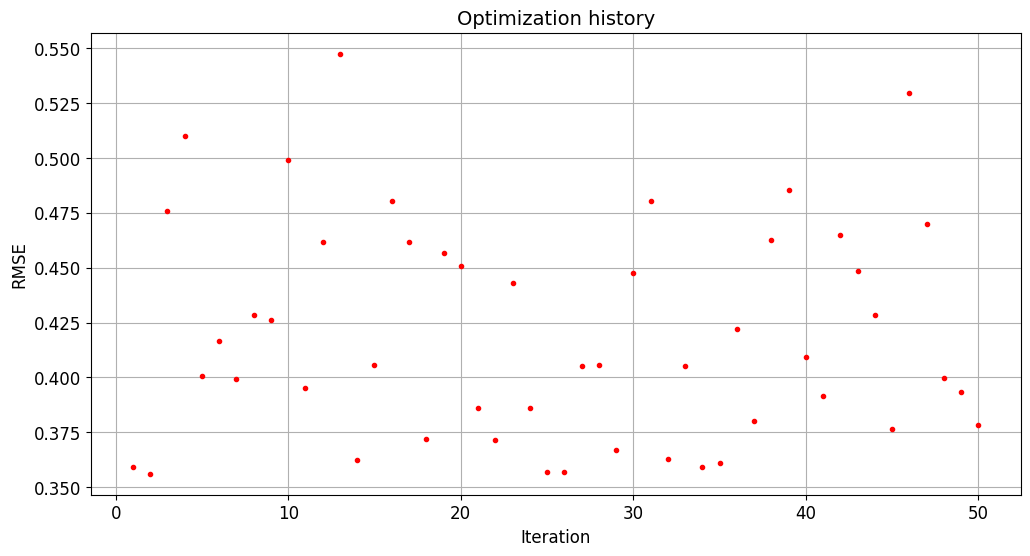

In [18]:
##Code for using hyperopt for hysperparameter search to optimze RMSE taken from
##https://www.kaggle.com/rendyk/bayesian-optimization-bayes-opt-or-fmin#hyperopt
##https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt

##Define the hyperparamterparamter space
xgbr_param_space = {'max_depth': hp.choice('max_depth', range(3,9)),
                    'learning_rate': hp.uniform('learning_rate',0.01,0.5),
                    'subsample': hp.uniform('subsample',0.5,1.0),
                    'n_estimators': hp.choice('n_estimators', range(100,1000)),
                    'reg_lambda': hp.uniform('reg_lambda',0,5), #L2 regularization
                    'reg_alpha': hp.uniform('reg_alpha',0,5), #L1 regularization
                    'min_child_weight': hp.uniform('min_child_weight',0,10),
                    'gamma': hp.uniform('gamma',0,0.5),
                    'colsample_bytree': hp.uniform('colsample_bytree',0.5,1.0)}

best = 0
##The function to be optimized by hyperopt.fmin(), i.e. output of this function is mean rmse (averaged over k-fold CV)
##which is being optimized by hyprOpt.fmin().
def xgbr_func(params):
    global best
    print(params)

    ##Define XGBoost regressor
    ##NOTE: couldn't find RMSE equivalent among inbuilt obj functions in xgboost
    ##https://xgboost.readthedocs.io/en/latest/parameter.html
    reg = XGBRegressor(tree_method='hist',objective='reg:squarederror', device="cuda",
                       random_state=random_seed,**params)
    ##Compute the mean score for kfold cross validation
    score = cross_val_score(reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    ##For keeping track of optimal f1-score, print the score everytime a better value is found
    if score > best:
        best = score
        print ('new best:', best)

    ##returning -ve of score because hyperopt.fmin() minimizes a function. So in our we are minimizing -ve of f1-score.
    return {'loss': -score, 'status': STATUS_OK}

##Start the timer for hyperparamter optimization
start = time.time()
##Max number of evaluations for hyperopt.fmin()
max_iterations = 50
##Find the optimal hyperparamter set. Also storing the optimization history
xgbr_param_space_indices, xgbr_trials = opt_hyperparameter(xgbr_param_space,xgbr_func,max_iterations)
##Obtain the hyperparamter values in the hyperparamter space defined by xgbc_param_space_indices
xgbr_best_hp = space_eval(xgbr_param_space,xgbr_param_space_indices)

print('It takes %s minutes' % ((time.time() - start)/60))
print('---------------Optimal Hyperparamter Set-------------------')
print(xgbr_best_hp)
print('---------------Optimization History-------------------')
optimization_history(xgbr_trials)

In [ ]:
# {'colsample_bytree': 0.7267732285661787, 'gamma': 0.015931896290695913, 'learning_rate': 0.27723768002238625, 'max_depth': 8, 'min_child_weight': 3.9686080798837695, 'n_estimators': 556, 'reg_alpha': 3.9868466922068864, 'reg_lambda': 4.089931900666492, 'subsample': 0.982537152357918}

In [21]:
# Get the best parameters
best_params = xgbr_best_hp
print(f"Best Parameters: {best_params}")

# Create a new model with the best parameters
best_model = XGBRegressor(**best_params, tree_method='hist',
                          objective='reg:squarederror', device="cuda")

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_model.predict(X_val)

# Evaluate the best model
print(f"RMSE: {rmse(y_val, y_pred_best):.2f}")
print(f"MAPE: {mape(y_val, y_pred_best):.2f}")

Best Parameters: {'colsample_bytree': 0.7267732285661787, 'gamma': 0.015931896290695913, 'learning_rate': 0.27723768002238625, 'max_depth': 8, 'min_child_weight': 3.9686080798837695, 'n_estimators': 556, 'reg_alpha': 3.9868466922068864, 'reg_lambda': 4.089931900666492, 'subsample': 0.982537152357918}
RMSE: 0.35
MAPE: 0.19
